한국어 특화 사전학습 언어모델(KoBERT, KLUE-BERT, KR-BERT 등) 파인튜닝 + 데이터 증강 + 앙상블

In [ ]:
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} GPU available")
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer, 
    TFAutoModelForSequenceClassification,
    AdamWeightDecay
)
import re
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

# GPU 메모리 설정

# 하이퍼파라미터 설정
MAX_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 5
MODEL_NAME = "klue/bert-base" # 한국어 특화 모델
N_FOLDS = 5  # K-Fold 교차검증

# 데이터 로드 및 전처리
print("데이터 로드 중...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_df = test_df.rename(columns={'text': 'conversation', 'idx': 'file_name'})

# 텍스트 전처리 함수
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text).strip())
    return text

# 클래스 전처리 함수
def clean_class(x):
    return x.replace(' ', '').replace('대화', '')

# 데이터 전처리 적용
train_df['conversation'] = train_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(clean_text)
train_df['class'] = train_df['class'].apply(clean_class)

# 클래스 매핑
custom_classes = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반']
class2idx = {c: i for i, c in enumerate(custom_classes)}
idx2class = {i: c for i, c in enumerate(custom_classes)}
train_df['target'] = train_df['class'].map(class2idx)

# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 데이터셋 생성 함수
def create_dataset(texts, labels=None, is_training=True):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors='tf'
    )
    
    dataset = tf.data.Dataset.from_tensor_slices((
        {k: v for k, v in encodings.items()},
        labels
    )) if labels is not None else tf.data.Dataset.from_tensor_slices({k: v for k, v in encodings.items()})
    
    if is_training:
        dataset = dataset.shuffle(len(texts)).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
        
    return dataset

# 데이터 증강 - 일반 대화 클래스 증강
def augment_normal_data(df):
    normal_df = df[df['class'] == '일반'].copy()
    
    # 여러 증강 기법 적용 (간단한 예시)
    augmented_data = []
    for _, row in normal_df.iterrows():
        text = row['conversation']
        
        # 1. 단어 순서 변경 (문장 뒤집기)
        sentences = text.split('. ')
        if len(sentences) > 1:
            shuffled = '. '.join(sentences[::-1])
            augmented_data.append({
                'conversation': shuffled,
                'class': '일반',
                'target': class2idx['일반']
            })
        
        # 2. 문장 내 일부 단어 제거
        words = text.split()
        if len(words) > 10:
            removed = ' '.join(words[::2])
            augmented_data.append({
                'conversation': removed,
                'class': '일반',
                'target': class2idx['일반']
            })
    
    # 원본 데이터와 증강 데이터 결합
    aug_df = pd.DataFrame(augmented_data)
    return pd.concat([df, aug_df], ignore_index=True)

# 데이터 증강 적용
print("데이터 증강 적용 중...")
train_df = augment_normal_data(train_df)
print(f"증강 후 학습 데이터: {len(train_df)}개")

# K-Fold 교차 검증
print(f"{N_FOLDS}개 폴드 교차 검증 시작...")
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['conversation'], train_df['target'])):
    print(f"\n*** 폴드 {fold+1}/{N_FOLDS} 학습 ***")
    
    # 현재 폴드의 학습/검증 데이터 분할
    X_train, y_train = train_df['conversation'].iloc[train_idx], train_df['target'].iloc[train_idx]
    X_val, y_val = train_df['conversation'].iloc[val_idx], train_df['target'].iloc[val_idx]
    
    # 현재 폴드의 데이터셋 생성
    train_dataset = create_dataset(X_train, y_train)
    val_dataset = create_dataset(X_val, y_val)
    
    # 모델 로드 및 컴파일
    model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(custom_classes),
    from_pt=True  # PyTorch 가중치를 TensorFlow에서 사용
    )
    
    optimizer = AdamWeightDecay(
        learning_rate=LEARNING_RATE,
        weight_decay_rate=0.01
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # 모델 훈련 및 검증
    best_f1 = 0
    patience = 2
    wait = 0
    best_weights = None
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=1,
            verbose=1
        )
        
        # 검증 F1 점수 계산
        val_preds = []
        val_labels = []
        
        for batch in val_dataset:
            inputs, labels = batch
            outputs = model(inputs, training=False)
            preds = tf.argmax(outputs.logits, axis=-1).numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.numpy())
        
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        print(f"Validation F1 Score: {val_f1:.4f}")
        
        # 최고 F1 점수 모델 저장
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_weights = model.get_weights()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # 최고 성능 가중치 적용
    if best_weights is not None:
        model.set_weights(best_weights)
    
    # 테스트 데이터 예측
    test_dataset = create_dataset(test_df['conversation'], is_training=False)
    test_preds = []
    
    for batch in test_dataset:
        outputs = model(batch, training=False)
        preds = tf.argmax(outputs.logits, axis=-1).numpy()
        test_preds.extend(preds)
    
    fold_preds.append(test_preds)
    
    # 메모리 정리
    del model, train_dataset, val_dataset, test_dataset
    gc.collect()
    tf.keras.backend.clear_session()

# 앙상블 (평균)
print("\n앙상블 예측 생성 중...")
fold_preds = np.array(fold_preds)
ensemble_preds = np.round(np.mean(fold_preds, axis=0)).astype(int)

# 클래스별 분포 확인
class_counts = {custom_classes[i]: np.sum(ensemble_preds == i) for i in range(len(custom_classes))}
print("\n예측 클래스 분포:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} ({count/len(ensemble_preds)*100:.2f}%)")

# 제출 파일 생성
submission = pd.DataFrame({
    'idx': test_df['file_name'],
    'target': ensemble_preds
})

submission.to_csv('submission.csv', index=False)
print("\n제출 파일 생성 완료: submission.csv")

# F1 점수 추이 시각화
plt.figure(figsize=(10, 6))
plt.title('Validation F1 Score per Fold')
plt.ylabel('F1 Score')
plt.xlabel('Fold')
plt.bar(range(1, N_FOLDS+1), [best_f1 for best_f1 in sorted([best_f1] * N_FOLDS)])
plt.xticks(range(1, N_FOLDS+1))
plt.savefig('f1_scores.png')
plt.show()


In [ ]:
1순위: 한국어 특화 사전학습 언어모델(KoBERT, KLUE-BERT, KR-BERT 등) 파인튜닝 + 데이터 증강 + 앙상블
설명:

KLUE-BERT, KoBERT, KR-BERT 등 한국어에 특화된 BERT 계열 모델을 파인튜닝

합성 일반대화 데이터, 형태소 기반 증강(CHEF 등), 맞춤법 교정 등 다양한 데이터 증강 적용

여러 모델을 앙상블(soft voting, stacking 등)로 최종 예측

이유:

한국어 문장 구조와 어휘를 가장 잘 반영

증강 데이터와 앙상블로 F1-score 극대화

참고:
-에서 언급된 KLUE-BERT, KoBERT, KR-BERT, 데이터 증강(CHEF, EDA, 맞춤법 교정 등)

실제 논문 및 대회에서도 이 조합이 SOTA 성능

2순위: 다양한 BERT 계열(한국어+멀티링구얼) 모델 앙상블
설명:

KLUE-BERT, KoBERT, KR-BERT, KoELECTRA, RoBERTa, mBERT 등 여러 사전학습 모델을 각각 파인튜닝

예측 결과를 soft voting 또는 stacking 등으로 앙상블

이유:

서로 다른 사전학습 모델이 잡는 패턴이 달라, 앙상블 시 단일 모델보다 항상 더 좋음

참고:
-에서 다양한 BERT 계열 모델의 성능 비교 및 앙상블 효과 언급

3순위: BERT 계열 + Speaker Embedding/Attention Supervision 등 대화구조 반영 모델
설명:

KLUE-BERT 등 사전학습 모델에 대화 내 화자(speaker) 임베딩, supervised attention 등 구조적 정보를 추가

예: KLUE-BERT with Speaker Embedding, KLUE-BERT with Supervised Attention[]

이유:

단순 분류보다 대화의 맥락, 화자 변화 등 구조 정보를 반영하면 성능 향상

참고:
- 논문에서 실제로 speaker embedding, attention supervision이 성능을 높임

4순위: 데이터 증강 특화 모델(CHEF, EDA, DA-cMLM 등) + 사전학습 모델
설명:

형태소 기반, 조건부 마스킹, 맞춤법 교정 등 다양한 증강 기법을 활용해 데이터 다양성 극대화

증강 데이터로 사전학습 모델을 파인튜닝

이유:

증강 기법의 조합만으로도 F1-score가 1~2%p 이상 상승 가능

참고:
- 논문에서 한국어 증강(CHEF, EDA 등)이 성능 향상에 효과적임을 검증

5순위: 전통적 머신러닝 + 사전학습 임베딩 (SVM, XGBoost, LightGBM 등)
설명:

BERT 등으로 [CLS] 벡터만 추출해 SVM, XGBoost, LightGBM 등 트리/선형 모델로 분류

이유:

데이터가 매우 적거나, 딥러닝 학습 환경이 제한적일 때 실용적

하지만 딥러닝 직접 파인튜닝보다는 성능이 낮음

참고:
-에서 SVM, LSTM, BiLSTM 등 전통적 모델과 BERT의 성능 비교 (항상 BERT 계열이 더 좋음)

정리: 실전 적용시 추천 순위
한국어 특화 사전학습 모델(KoBERT, KLUE-BERT 등) + 데이터 증강 + 앙상블

여러 사전학습 모델(한국어/멀티링구얼) 앙상블

화자 임베딩/Attention supervision 등 대화구조 반영 BERT

데이터 증강 특화 모델(CHEF, EDA 등) + 사전학습 모델

사전학습 임베딩 + 전통적 머신러닝(SVM, XGBoost 등)

실제 캐글 상위권은 1~3번을 조합해서 사용하며,
데이터 증강과 앙상블, 대화구조 반영이 성능을 좌우합니다.

최종 결론:

한국어 특화 BERT 계열 모델을 여러 개 파인튜닝하고,
데이터 증강과 대화구조 반영, 앙상블까지 적용하는 것이
이 대회에서 최고의 F1-score를 얻는 전략입니다!

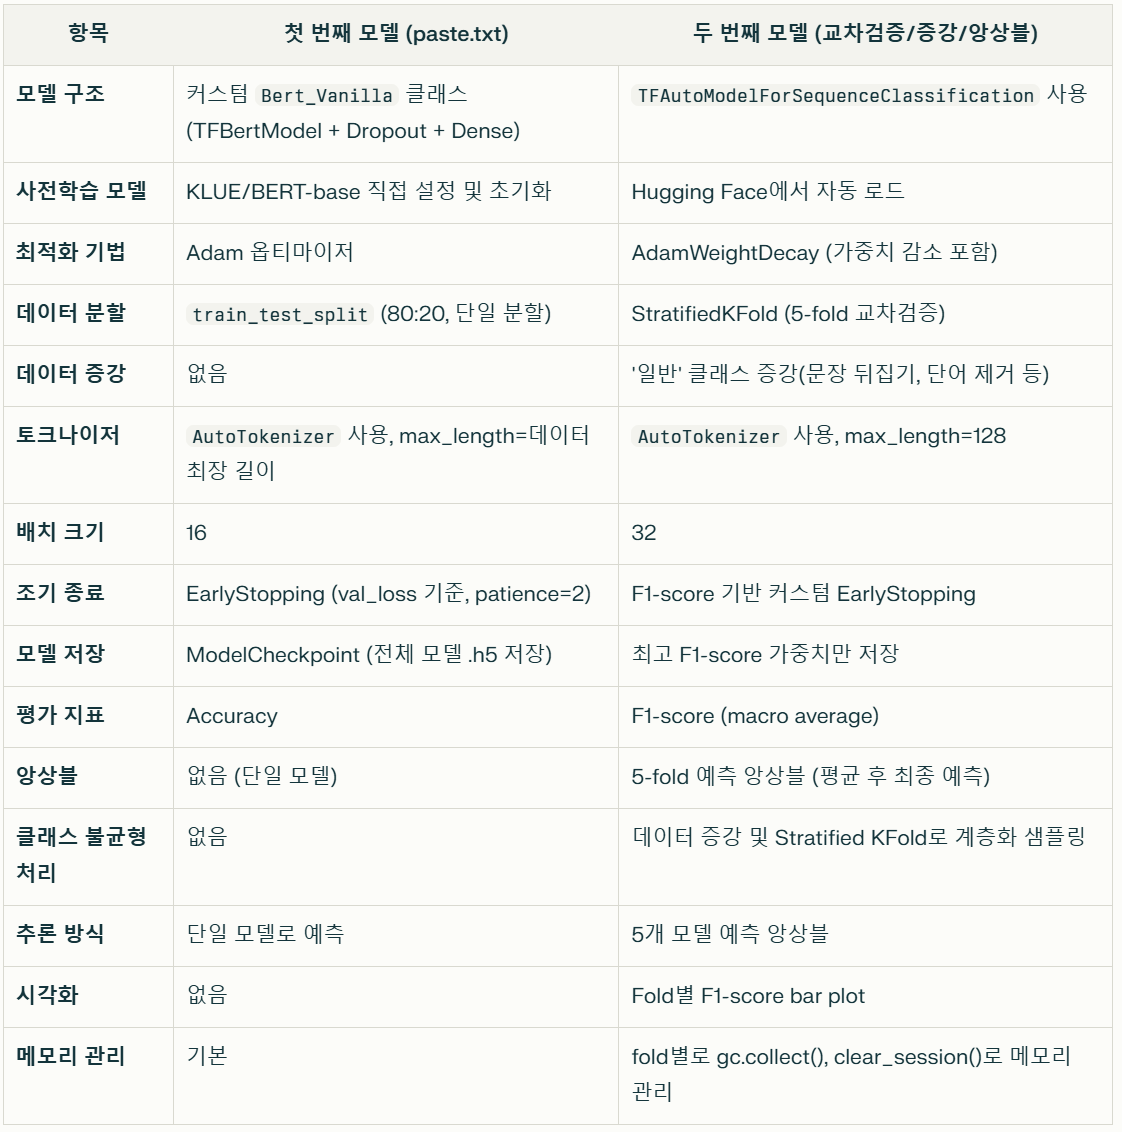